In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import seaborn as sns

In [515]:
train_data = pd.read_csv('./House_price/train.csv')
test_data = pd.read_csv('./House_price/test.csv')

In [516]:
train_data = train_data.reset_index(drop=True)

In [517]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [518]:
#删掉离群的值
sns.scatterplot(train_data['GrLivArea'], train_data['SalePrice'])

AttributeError: module 'seaborn' has no attribute 'scatterplot'

In [519]:
train_data = train_data[(train_data['GrLivArea'] < 4000) | 
                       (train_data['SalePrice'] > 700000)]

In [520]:
sns.scatterplot(train_data['GrLivArea'], train_data['SalePrice'])

AttributeError: module 'seaborn' has no attribute 'scatterplot'

/home/hadoop/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


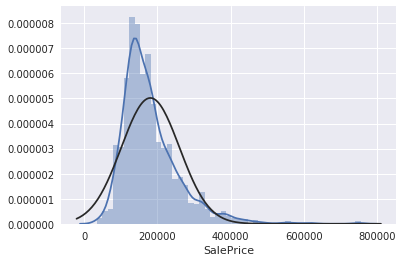

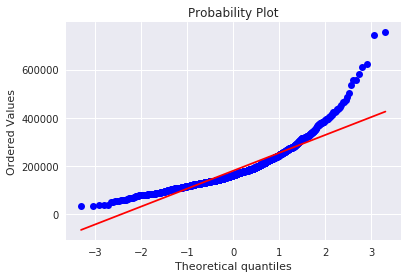

In [521]:
#目标变量的分析
from scipy.stats import *
sns.distplot(train_data['SalePrice'], fit=norm)
fig = plt.figure()
probplot(train_data['SalePrice'], plot=plt)
plt.show()

/home/hadoop/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


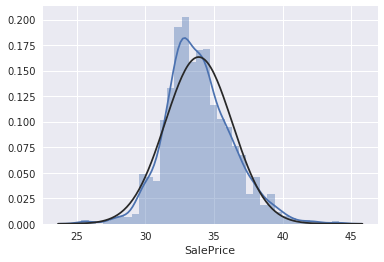

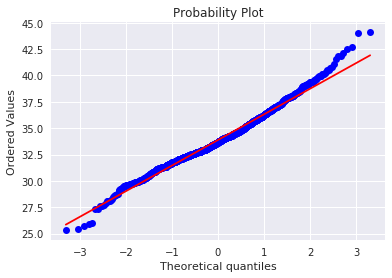

In [522]:
from scipy.special import boxcox1p
train_data['SalePrice'] = boxcox1p(train_data['SalePrice'], 0.15)
sns.distplot(train_data['SalePrice'], fit=norm)
fig = plt.figure()
probplot(train_data['SalePrice'], plot=plt)
plt.show()

In [523]:
train_data[train_data.index==666]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
666,667,60,RL,NaN,18450,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Abnorml,32.282458


In [524]:
n_train = train_data.shape[0]
n_test = test_data.shape[0]
all_data = pd.concat([train_data, test_data], ignore_index=True, sort=False)
all_data.drop(columns=['SalePrice','Id'], inplace=True)
all_data.loc[2574, ['GarageType']] = np.nan
all_data.loc[2124,['GarageType', 'GarageCars', 'GarageArea']] = np.nan
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [525]:
all_data.loc[2124,'GarageYrBlt']

nan

In [526]:
all_data_na = all_data.isnull().sum()/len(all_data)*100
all_data_na = all_data_na[all_data_na.values != 0]
all_data_na = pd.DataFrame({'Miss':all_data_na.sort_values(ascending=False)})

Text(0,0.5,'Percent of missing values')

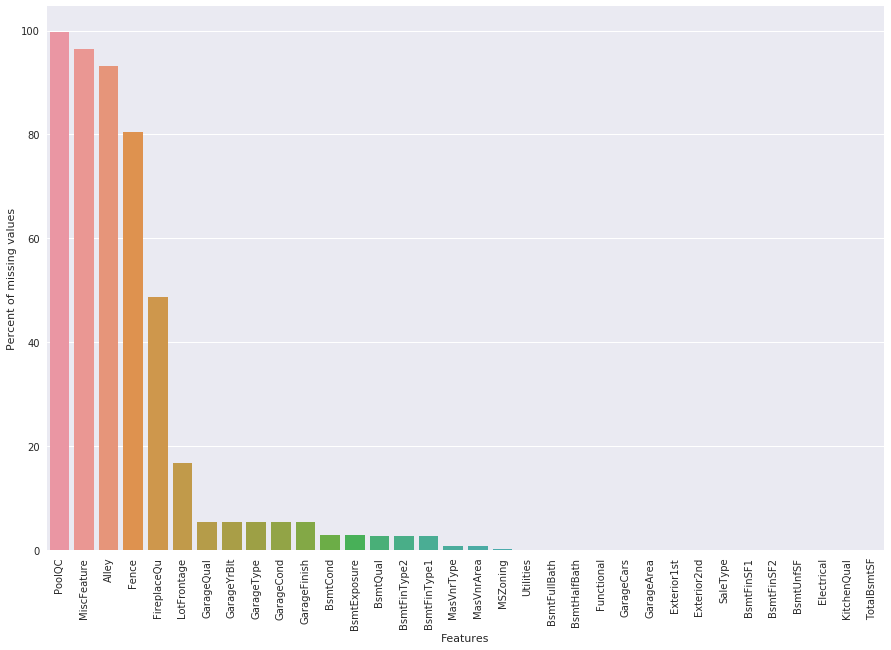

In [527]:
plt.figure(figsize=(15, 10))
sns.barplot(all_data_na.index, all_data_na['Miss'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percent of missing values')

In [528]:
#泳池质量
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [529]:
#一些其它维度没有提及的杂项
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [530]:
#小巷的类型?
all_data['Alley'] = all_data['Alley'].fillna('None')

In [531]:
#围栏的质量
all_data['Fence'] = all_data['Fence'].fillna('None')

In [532]:
#壁炉的质量
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

transform:<br>
1.只允许在同一时间在一个Series上进行一次转换，如果定义列‘a’ 减去列‘b’，  则会出现异常；<br>
2.必须返回与 group相同的单个维度的序列（行）<br>
apply:<br>
1.不同于transform只允许在Series上进行一次转换， apply对整个DataFrame作用<br>
2.apply隐式地将group 上所有的列作为自定义函数<br>

In [533]:
#到繁华街道的英里数
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

In [534]:
#车库的内部装饰
len(all_data[all_data['GarageFinish'].isna()])

159

In [535]:
#车库建成的日期
len(all_data[all_data['GarageYrBlt'].isna()])

159

In [536]:
#车库质量
len(all_data[all_data['GarageQual'].isna()])

159

In [537]:
#车库情况
len(all_data[all_data['GarageCond'].isna()])

159

In [538]:
#车库的地点
len(all_data[all_data['GarageType'].isna()])

159

In [539]:
#车库能放车的数量
all_data[all_data['GarageCars'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2124,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,Shed,1000,9,2008,WD,Normal
2574,70,RM,50.0,9060,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,None,0,3,2007,WD,Alloca


In [540]:
#车库的大小
len(all_data[all_data['GarageArea']==0])

157

In [541]:
#车库的地点，
for col in ['GarageType', 'GarageCond', 'GarageQual', 'GarageFinish']:
    all_data[col] = all_data[col].fillna('None')

In [542]:
for col in ['GarageArea', 'GarageCars', 'GarageYrBlt']:
    all_data[col] = all_data[col].fillna(0)

In [543]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode().iloc[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode().iloc[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [552]:
#检查缺失值
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [558]:
all_data.dtypes[all_data.dtypes != object].index.values

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'], dtype=object)